# Work out a way to find the path between a start and endpoint

In [24]:
import numpy as np
import matplotlib.pyplot as plt 
import lumiere as lm
lm.loadstyle(True)

Using KIT colors.
Custom style set.


In [25]:
width = 200
height = 100

In [26]:
def reflect(pos, wall):
    if wall == 'AB':
        return [pos[0], -pos[1]]
    if wall == 'DC':
        return [pos[0], 2*height - pos[1]]
    if wall == 'BC':
        return [2*width - pos[0], pos[1]]
    if wall == 'DA':
        return [-pos[0], pos[1]]
    print('Error')

def calculateAngle(A, Bstar):
    return np.rad2deg(2*np.pi + np.arctan2(Bstar[1]-A[1], Bstar[0]-A[0]))


def line(x, a, b):
    return x*a + b

def angle2line(x, x0, y0, alpha0):
    return np.tan(np.deg2rad(alpha0))*(x-x0) + y0

def inv_angle2line(y, x0, y0, alpha0):
    return (y-y0)/np.tan(np.deg2rad(alpha0)) + x0
    
def newCollsionPoint(x, y, alpha):
    yleft = angle2line(0, x, y, alpha)
    yright = angle2line(width, x, y, alpha)
    xbottom = inv_angle2line(0, x, y, alpha)
    xtop = inv_angle2line(height, x, y, alpha)


    if alpha < 90: # collision top-right
        if xtop > width:
            return (width, yright, 180-alpha) # collision right vertical
        else: 
            return (xtop, height, 360-alpha) # collision top horizontal
        
    if alpha < 180: # collsion top left
        if yleft > height:
            return (xtop, height, 360-alpha) # collision top horizontal

        else:
            return (0, yleft, 180-alpha) # collision left vertical


    if alpha < 270: # collsion bottom left
        if xbottom < 0:
            return (0, yleft, 540-alpha) # collision left vertical
        else:
            return (xbottom, 0, 360-alpha) # collision bottom horizontal
        
    # collision bottom right
    if xbottom > width:
        return (width, yright, 540-alpha) # collision right vertical
    else:
        return (xbottom, 0, 360-alpha) # collision bottom horizontal
    


In [27]:
def plotTable(mirrorpath, aimpath):
    x_coords = [pos[0] for pos in mirrorpath]
    y_coords = [pos[1] for pos in mirrorpath]

    plt.plot(x_coords, y_coords, '--', color='C1', label='MIRROR CALCULATION')

    plt.plot([aimpath[0][0], x_coords[0-1]], [aimpath[1][0], y_coords[-1]], ':', color='C5', label='AIM PATH')
    plt.plot(x_coords[-1], y_coords[-1], 'o', color='r', label='AIM TARGET')

    plt.plot(*aimpath, color='C2', label='PLAYPATH')

    
    plt.plot([0, width, width, 0, 0], [0, 0, height, height, 0], color='k')
    plt.scatter(*A, color='C0', label='BEGIN')
    plt.scatter(*B, color='C1', label='END')
    plt.text(5, 3, 'A')
    plt.text(203, 3, 'B')
    plt.text(203, 3, 'B')
    plt.text(203, 97, 'C')
    plt.text(5, 97, 'D')
    

### Best to think about this in terms of billiard

- we want to play from $A$ to $B$
- so we specify the order of walls $AB, BC, CD, DA$ we want to play of
- we aim at the virtual image of $B$, that is created by mirroring in an inverted order
- what we look for is then the angle $\alpha$
$$
    \alpha = \arctan \left( \frac{y_{B^*}- y_{A}}{x_{B^*} - x_A} \right)
$$

[[78, 87], [322, 87], [-322, 87], [722, 87], [722, -87]]


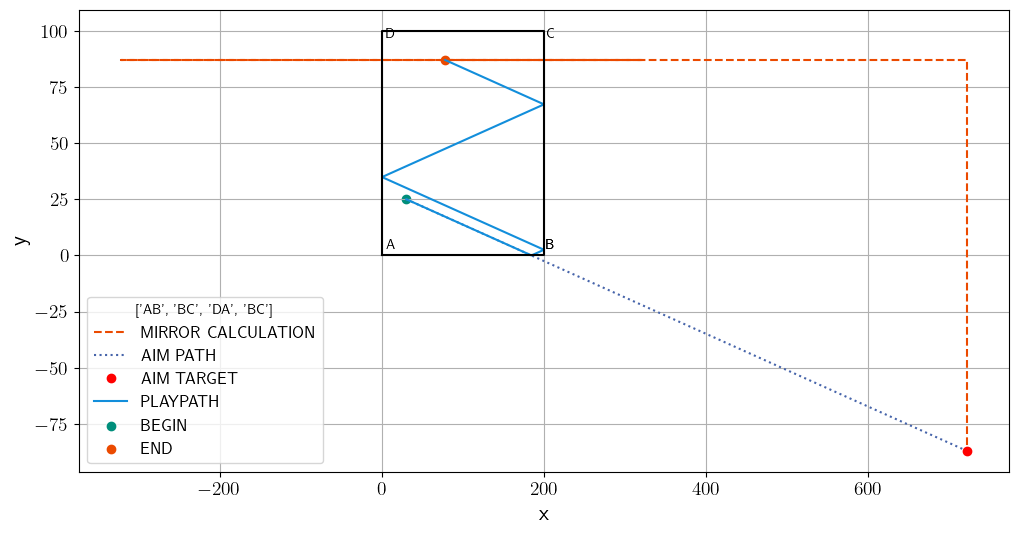

In [28]:
A = [30, 25]
B = [78, 87]
width = 200
height = 100

path = [B]
bounces = ['AB', 'BC', 'DA', 'BC'] #from A to B


for ref in bounces[::-1]:
    nup = reflect(path[-1], ref)
    path.append(nup)
print(path)
# this is the virtual path


#this is the angle going out from A
alpha = calculateAngle(A, path[-1])
x0v, y0v, a0v = [A[0]], [A[1]], [alpha]

for i  in range(len(bounces)+1):
    xx, yy, aa = newCollsionPoint(x0v[-1], y0v[-1], a0v[-1])
    x0v.append(xx)
    y0v.append(yy)
    a0v.append(aa)

x0v[-1] = B[0]
y0v[-1] = B[1]
plotTable(path, [x0v, y0v])


plt.xlabel('x')
plt.ylabel('y')
plt.legend(title=str(bounces))
plt.show()


# Load `collision-builder.py` and work out a new function

- Combine this into one function
  - get: `start_position` `end_position`, `list_of_bounces`
    - calculate virtual target
    - calcualte angle $\alpha$ to aim for
    - calculate the path that is being reflected on
    - edit the last point to end in $B$
- Return the path


In [29]:
import sys
cdir = %pwd
sys.path.append(cdir+ '/')
from collision_builder import *

### function to add

In [33]:
def addPrimaryFromTo(self, start_pos, end_pos, wall_collisions):
    '''
    - start_pos: a (x, y)
    - end_pos: b (x, y)
    - wall collisions: Combination of "AB", "BC", "CD", "DA" 
        (List 1d, or Lists 2d for multiple paths) in time-forward order (a -> b)
    ---------------------------------------
    Calculate and Save the path(s) to be taken from a -> b
    '''

    if np.ndim(wall_collisions) == 1:
        wall_collisions = [wall_collisions]

    n_bounces = []
    # allow multiple paths to be computed
    for this_wall_collision_path in wall_collisions:

        # calculate virtual endpoint
        virtual_end_pos = end_pos.copy()
        for coll in this_wall_collision_path[::-1]:
            virtual_end_pos = reflect(virtual_end_pos, coll)


        # calculate angle going out from a, aimed at virtual b
        start_alpha = calculateAngle(start_pos, virtual_end_pos)

        self.incoming_angles.append(start_alpha)
        n_bounces.append(len(this_wall_collision_path))


    # compute the paths of collision
    self.calculatePrimaryPaths(n_bounces)

    # need to add a last point: b
    for i in len(self.calculatePrimaryPaths):
        self.calculatePrimaryPaths[i].append(list(end_pos))

